## In this Jupyter Notebook I defined several functions to analyze large gene/protein sets in terms of their underlying subnetworks

### PPI data is automatically retrieved and further creation of subnetworks performed
#### Those subnetworks (communities) are then funtionally annotated, plotted and shown next to the wordclouds of their functional enrichments

#### Known issues:
The **plotCiros** and **plotArc** function won't work if your partition ives you more than 11 communities, as the underlying nxviz package does not support more than 12 colors. This can be solved by manually changing the code in the nxviz package, however, this might be too complicated for non-versatile programmers (in case you want to do it you just have to check the error code, go to the respective line in the respective nxviz module and change the colormap to a continuous one and disable the error if the nuber of categories exceeds 12)

#### Installation:
This Notebook uses a variety of python packages. whichever package is missing for you when importing it can be installer running 
```
pip install <package>
```
However, be aware that 'community' has to be installed as 'python-louvain' and 'sklearn' as 'scikit-learn'.
Other than that, everything should work out prpoerly. If there is a problem, please contact me or raise an issues on 

In [55]:
# some of the libraries you have to install:
# install them e.g. in your conda command line or here directly with:
#<%pip install ...>
# pip install wordcloud matplotlib seaborn pandas python-louvain nxviz seaborn scikit-learn


run the following cell for function definition

In [1]:
import requests
import networkx as nx
import pandas as pd
import numpy as np
import community
import json
import pathlib
from matplotlib import cm, rcParams, cycler
import matplotlib.pyplot as plt
import nxviz as nv 
from nxviz import annotate
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from IPython.display import Image, display
import io

def get_string_ppi(genes, min_score=400, organism='Homo sapiens'):
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "tsv"
    method = "network"

    # Convert organism to STRING DB identifier
    if str(organism).lower() == 'homo sapiens' or str(organism).lower() == 'human' or str(organism) == "9606":
        organism = 9606
    elif str(organism).lower() == 'mus musculus' or str(organism).lower() == 'mouse' or str(organism) == "10090":
        organism = 10090
    else:
        print("Organisms should be 'human' or 'mouse' or the string identifier of your organisms.\nIf the code fails, make sure to use the correct identifier or the suggested strings")
        
    ## Construct URL
    request_url = "/".join([string_api_url, output_format, method])

    ## Set parameters
    my_genes = genes

    params = {
        "identifiers" : "%0d".join(my_genes), # your protein
        "species" : organism, # species NCBI identifier 
        "caller_identity" : "www.awesome_app.org", # your app name
        "required_score" : min_score #required score
    }

    # create df for network creation
    interactions = []

    ## Call STRING
    response = requests.post(request_url, data=params)

    for line in response.text.strip().split("\n"):
        l = line.strip().split("\t")
        interactions.append(l)

    # manage string output
    interactions = pd.DataFrame(interactions)
    interactions.columns = interactions.iloc[0]
    interactions.drop(0, inplace=True)
    interactions = interactions[["preferredName_A", "preferredName_B", "score"]]
    interactions["score"] = pd.to_numeric(interactions["score"])
    
    # Create a new graph
    G=nx.Graph(name='Protein Interaction Graph')
    interactions = np.array(interactions)
    for i in range(len(interactions)):
        interaction = interactions[i]
        a = interaction[0] # protein a node
        b = interaction[1] # protein b node
        w = float(interaction[2]) # score as weighted edge where high scores = low weight
        G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

    return G

def createCommunities(G, iterations=10):
    
    partition_list = []
    modularity_list = []
    for i in range(iterations):

        partition = community.best_partition(G, weight='weight')
        modularity = community.modularity(partition, G, weight='weight')

        partition_list.append(partition)
        modularity_list.append(modularity)

    max_value = max(modularity_list)
    max_index = modularity_list.index(max_value)
    
    print("The best modularity Q based on the networkx is {}".format(max_value))
    return partition_list[max_index]

def checkFuncSignificance(G, partition, organism, sig_only, categories=["Process", "Function", "Component", "KEGG", "WikiPathways", "RCTM"]):
    
    # Convert organism to STRING DB identifier
    if str(organism).lower() == 'homo sapiens' or str(organism).lower() == 'human' or str(organism) == "9606":
        organism = 9606
    elif str(organism).lower() == 'mus musculus' or str(organism).lower() == 'mouse' or str(organism) == "10090":
        organism = 10090
    else:
        print("Organisms should be 'human' or 'mouse' or the string identifier of your organisms.\nIf the code fails, make sure to use the correct identifier or the suggested strings")
       
    # get lists of all communites
    communities = [[] for x in range(len(set(partition.values())))]
    for gene, comm_num in partition.items():
        communities[comm_num].append(gene)
    
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "json"
    method = "enrichment"


    sigCommNumbers = set()
    commNumbers = set()
    funcAnnots = dict()

    for i in range(len(communities)):
        protein_list = communities[i]

        ## Construct URL
        request_url = "/".join([string_api_url, output_format, method])

        #9606 for human, 10090 for mouse
        params = {
            "identifiers" : "%0d".join(protein_list), # your protein
            "species" : organism, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name
            }
        ## Call STRING
        response = requests.post(request_url, data=params)

        ## Read and parse the results
        data = json.loads(response.text)
        anyProcessSig = False
        commNumbers.add(i)

        for row in data:
            term = row["term"]
            preferred_names = ",".join(row["preferredNames"])
            fdr = float(row["fdr"])
            description = row["description"]
            category = row["category"]
            
            if (not sig_only) or (category in categories and fdr < 0.05):

                anyProcessSig = True
                sigCommNumbers.add(i)
        
        if anyProcessSig:
            funcAnnots[i] = pd.DataFrame(data)
        
        # create dict for sig partition and attributes to add for nodes
        sigPartition=dict()
        attrs = dict()
        node_set = set()
        for n in G.nodes:
            node_set.add(n)

        # add comm num to nodes. Assign -1 if node is not part of any significant comm
        for comm_num in sigCommNumbers:
            for gene in communities[comm_num]:        
                attrs.update({gene:{"community" : comm_num}})
                node_set.remove(gene)
                sigPartition[gene] = comm_num

        for gene in node_set:
            sigPartition[gene] = -1
            attrs.update({gene:{"community" : -1}})
            
        # add attributes to each node of graph
        nx.set_node_attributes(G, attrs)

    return G, sigPartition, funcAnnots

def plotArc(G, partition, sig_only=True, organism=9606, legend=True):
    
    pathlib.Path("./ArcPlots/").mkdir(parents=True, exist_ok=True)

    G, sigPartition, funcAnnots = checkFuncSignificance(G, partition, organism, sig_only=sig_only)
    
    %config InlineBackend.figure_format = 'retina'
    %load_ext autoreload
    %autoreload 2
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    g = nv.arc(G, node_color_by="community", group_by="community", edge_color_by="weight", edge_lw_by="weight")
    annotate.arc_group(G, group_by="community")
    g.get_figure().set_size_inches(10,10)

    plt.tight_layout()
    plt.autoscale()
    
    if legend:
        cmap = plt.cm.viridis
        custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                       Line2D([0], [0], color=cmap(.5), lw=4),
                       Line2D([0], [0], color=cmap(1.), lw=4)]
        ax.legend(custom_lines, [400, 700, 999], title="combined score")
        
    file_name = "ArcPlots/community " + str(commNum) + "'s_arc_plot.png"
    print("Saving arc plots to %s" % file_name)
    plt.savefig(file_name)
    
def plotCircos(G, partition, sig_only=True, organism=9606, legend=True):
    
    pathlib.Path("./CircosPlots/").mkdir(parents=True, exist_ok=True)

    G, sigPartition, funcAnnots = checkFuncSignificance(G, partition, organism, sig_only=sig_only)
    
    %config InlineBackend.figure_format = 'retina'
    %load_ext autoreload
    %autoreload 2
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    g = nv.circos(G, node_color_by="community", group_by="community", edge_color_by="weight", edge_lw_by="weight")
    annotate.circos_group(G, group_by="community")
    g.get_figure().set_size_inches(10,10)

    plt.tight_layout()
    plt.autoscale()
    
    if legend:
        cmap = plt.cm.viridis
        custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                       Line2D([0], [0], color=cmap(.5), lw=4),
                       Line2D([0], [0], color=cmap(1.), lw=4)]
        ax.legend(custom_lines, [400, 700, 999], title="combined score")
        
    file_name = "CircosPlots/community " + str(commNum) + "'s_circos_plot.png"
    print("Saving circos plots to %s" % file_name)
    plt.savefig(file_name)

def plotWordclouds(G, partition, sig_only=True, organism=9606, categories=["Process", "Function", "Component", "KEGG", "WikiPathways", "RCTM"]):
    
    pathlib.Path("./WordClouds/").mkdir(parents=True, exist_ok=True)
    
    G, sigPartition, funcAnnots = checkFuncSignificance(G, partition, organism, sig_only=sig_only, categories=categories)

    # Create a color map
    colors = sns.color_palette('Dark2', len(categories)).as_hex()
    color_map = dict(zip(categories, colors))

    for commNum, df in funcAnnots.items():
        df = df[df['category'].isin(categories)]
        
        # Create a word cloud
        wc = WordCloud(background_color='white')
        weights = dict(zip(df['description'], -np.log10(df['fdr'])))
        wc.generate_from_frequencies(weights)
        
        # Recolor the words
        def color_func(word, *args, **kwargs):
            category = df.loc[df['description'] == word, 'category'].values[0]
            return color_map[category]
        wc.recolor(color_func=color_func)
        
        # Display the word cloud
        plt.figure(commNum)
        plt.title(f'Community {commNum}: Functional Annotation')
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        
        # Create legend
        patches = [mpatches.Patch(color=color, label=category) for category, color in color_map.items()]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        file_name = "WordClouds/community " + str(commNum) + "'s_wordcloud.png"
        print("Saving word clouds to %s" % file_name)
        plt.savefig(file_name)
        plt.show()
        plt.close()

def plotPPI(G, partition, sig_only=True, organism=9606):
    
    pathlib.Path("./PPI_networks/").mkdir(parents=True, exist_ok=True)
    
    G, sigPartition, funcAnnots = checkFuncSignificance(G, partition, organism, sig_only=sig_only)

    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "image"
    method = "network"
    
    request_url = "/".join([string_api_url, output_format, method])
    
    for commNum in set(sigPartition.values()):
        commGeneSet = [k for k, v in sigPartition.items() if v == commNum]
        
        params = {
        "identifiers" : "%0d".join(commGeneSet), # your protein
        "species" : organism, # species NCBI identifier 
        "network_flavor": "confidence", # show confidence links
        "caller_identity" : "www.awesome_app.org" # your app name
        }
        
        response = requests.post(request_url, data=params)
        
        file_name = "PPI_networks/community " + str(commNum) + "'s_network.png"
        print("Saving interaction network to %s" % file_name)

        with open(file_name, 'wb') as fh:
            fh.write(response.content)
        
        image = Image(response.content)
        display(image)

        
def plotWordCloudPPI(G, partition, sig_only=True, organism=9606, categories=["Process", "Function", "Component", "KEGG", "WikiPathways", "RCTM"]):
    
    pathlib.Path("./WordCloudPPI_networks/").mkdir(parents=True, exist_ok=True)
    
    G, sigPartition, funcAnnots = checkFuncSignificance(G, partition, organism, 
                                                        sig_only=sig_only, categories=categories)
        
    # Create a color map
    colors = sns.color_palette('Dark2', len(categories)).as_hex()
    color_map = dict(zip(categories, colors))

    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "image"
    method = "network"
    
    request_url = "/".join([string_api_url, output_format, method])
    
    # create dict of commNum: all comm genes
    allCommGeneSets = dict()
    for commNum in pd.Series(sigPartition.values()).sort_values().unique():
        commGeneSet = [k for k, v in sigPartition.items() if v == commNum]
        allCommGeneSets[commNum] = commGeneSet
    
    #add comm -1 to funcAnnots:
    funcAnnots[-1] = pd.DataFrame({'description': ['No significant functional enrichment'],
                                    'fdr': [0.05],
                                    'category': ['RCTM']
                                    })
    
    for commNum, df in funcAnnots.items():
        df = df[df['category'].isin(categories)]

        # Create a word cloud
        wc = WordCloud(background_color='white')
        weights = dict(zip(df['description'], -np.log10(df['fdr'])))
        wc.generate_from_frequencies(weights)
        
        # Recolor the words
        def color_func(word, *args, **kwargs):
            category = df.loc[df['description'] == word, 'category'].values[0]
            return color_map[category]
        wc.recolor(color_func=color_func)
        
        # PPI network part
        commGeneSet = allCommGeneSets[commNum]
        #commNum = pd.Series(sigPartition.values()).sort_values().unique()[i]
        
        params = {
        "identifiers" : "%0d".join(commGeneSet), # your protein
        "species" : organism, # species NCBI identifier 
        "network_flavor": "confidence", # show confidence links
        "caller_identity" : "www.awesome_app.org" # your app name
        }
        
        response = requests.post(request_url, data=params)
        
        # Create a figure with two subplots (1 row, 2 columns)
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Display the image in the first subplot
        img = mpimg.imread(io.BytesIO(response.content))
        axs[0].imshow(img)
        axs[0].axis('off')  # Hide the axes on the image plot
       
        # Display the word cloud
        #plt.figure(i)
        #plt.title(f'Community {i}: Functional Annotation')
        axs[1].imshow(wc, interpolation='bilinear')
        axs[1].axis('off')
        axs[1].set_title(f'Community {commNum}: Functional Annotation')
        
        # Create legend
        patches = [mpatches.Patch(color=color, label=category) for category, color in color_map.items()]
        axs[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        file_name = "WordCloudPPI_networks/community " + str(commNum) + "'s_ppi_wordcloud.png"
        print("Saving PPI word clouds to %s" % file_name)
        plt.savefig(file_name)
        plt.show()
        plt.close()
        
    return allCommGeneSets, funcAnnots
    


C:\Users\nruff\miniconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


Provide your own gene list for the analysis

all plotting functions will create subfolders to store your plots where this script is located

*categories* will determine which functional databases should be considered for the analyis.

Default: All Go-Terms and Pathway databases in stringDB (categories=["Process", "Function", "Component", "KEGG", "WikiPathways", "RCTM"])

If only pathway databases are wished, run the plotting functions with categories=["KEGG", "WikiPathways", "RCTM"]

For other options, create your own categories out of the following databases:
'COMPARTMENTS',
 'Component',
 'DISEASES',
 'Function',
 'HPO',
 'InterPro',
 'KEGG',
 'Keyword',
 'NetworkNeighborAL',
 'PMID',
 'Pfam',
 'Process',
 'RCTM',
 'SMART',
 'TISSUES',
 'WikiPathways'

The best modularity Q based on the networkx is 0.587622414147822
Saving PPI word clouds to WordCloudPPI_networks/community 0's_ppi_wordcloud.png


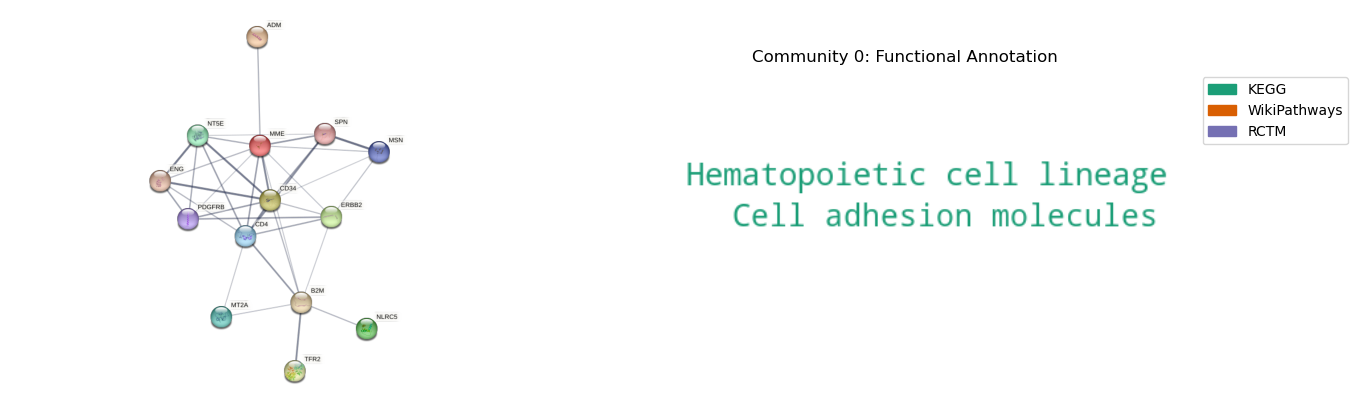

Saving PPI word clouds to WordCloudPPI_networks/community 3's_ppi_wordcloud.png


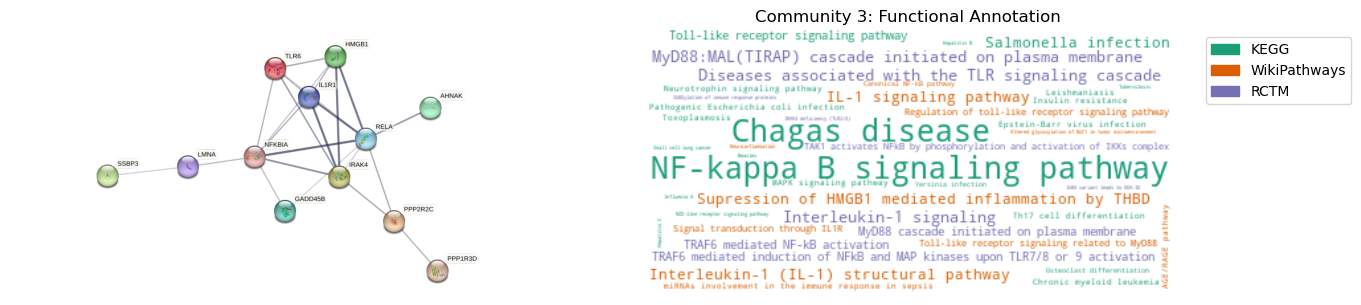

Saving PPI word clouds to WordCloudPPI_networks/community 4's_ppi_wordcloud.png


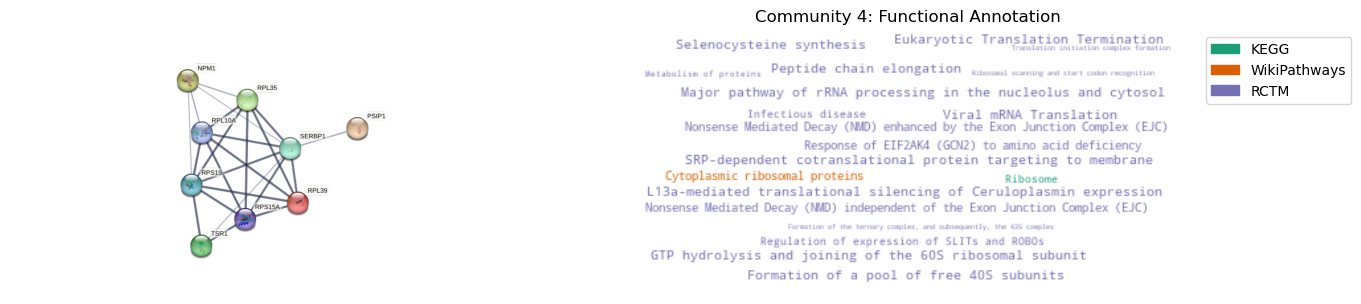

Saving PPI word clouds to WordCloudPPI_networks/community 5's_ppi_wordcloud.png


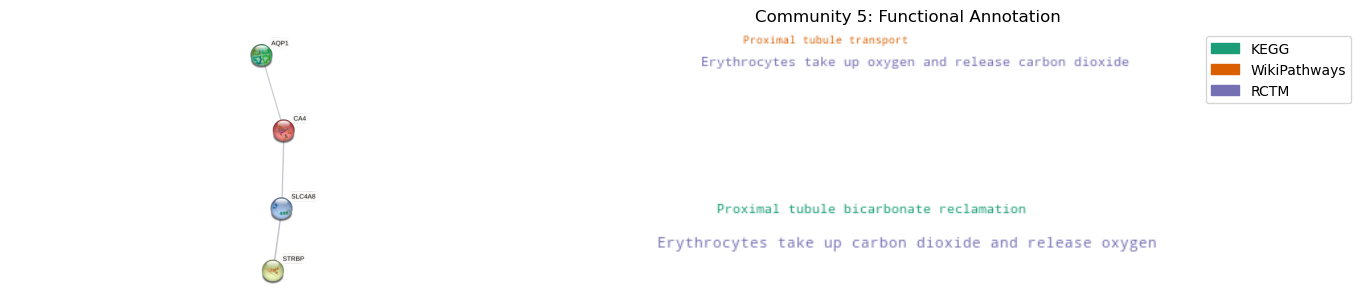

Saving PPI word clouds to WordCloudPPI_networks/community 8's_ppi_wordcloud.png


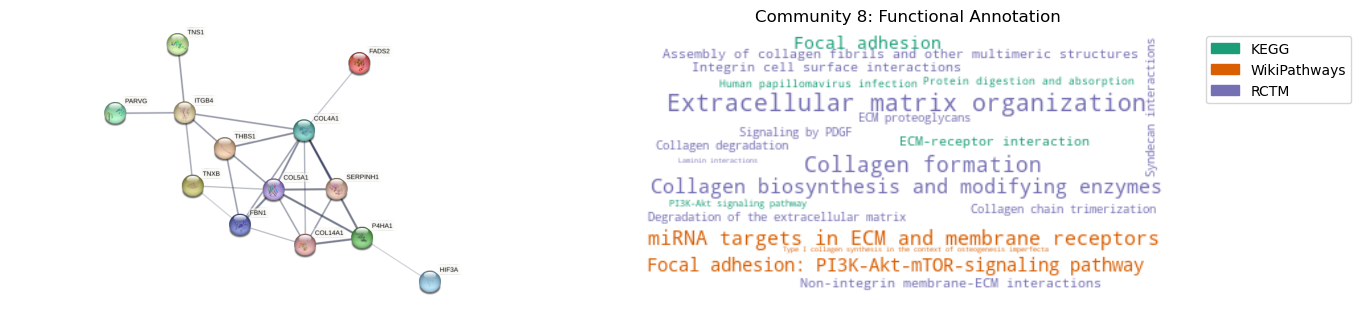

Saving PPI word clouds to WordCloudPPI_networks/community 10's_ppi_wordcloud.png


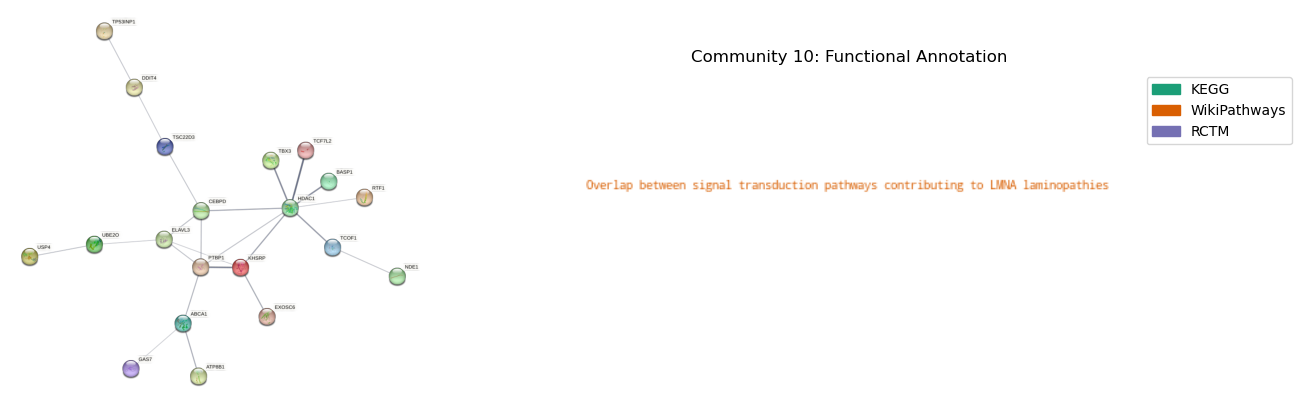

Saving PPI word clouds to WordCloudPPI_networks/community 11's_ppi_wordcloud.png


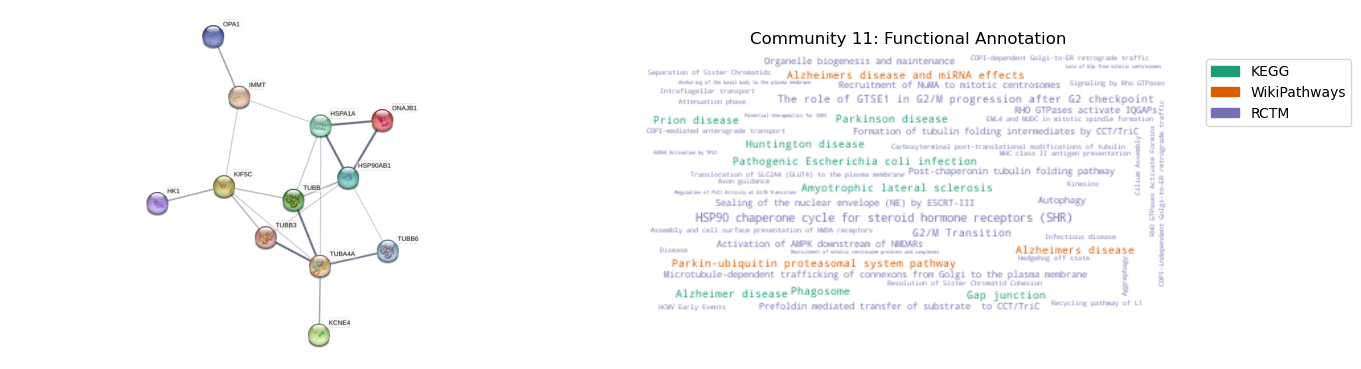

Saving PPI word clouds to WordCloudPPI_networks/community -1's_ppi_wordcloud.png


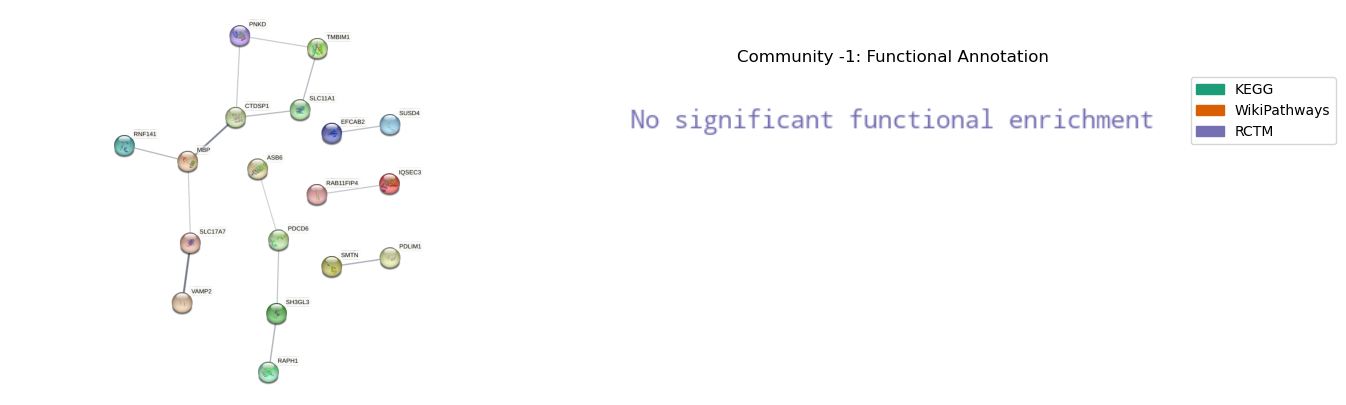

Saving word clouds to WordClouds/community 0's_wordcloud.png


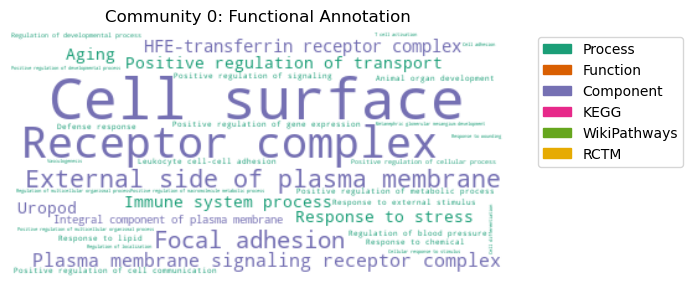

Saving word clouds to WordClouds/community 1's_wordcloud.png


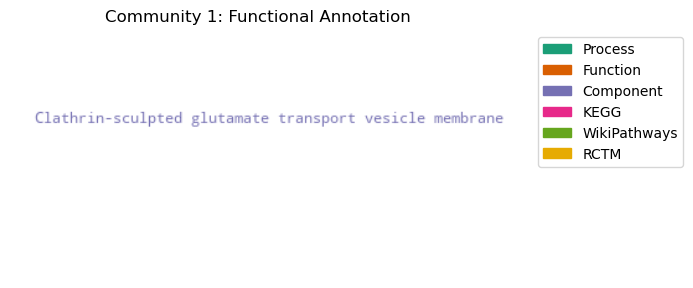

Saving word clouds to WordClouds/community 3's_wordcloud.png


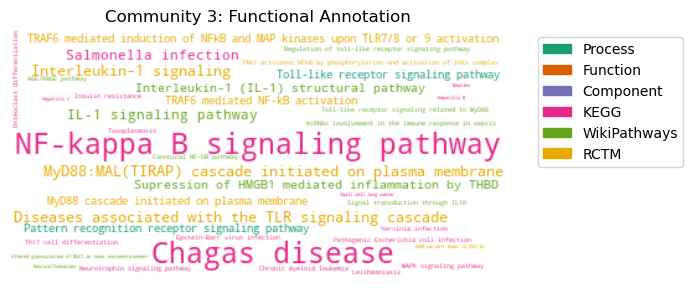

Saving word clouds to WordClouds/community 4's_wordcloud.png


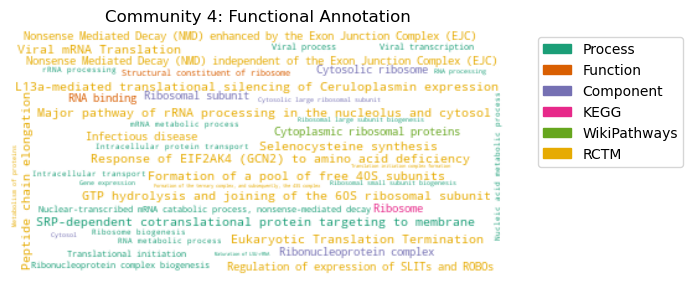

Saving word clouds to WordClouds/community 5's_wordcloud.png


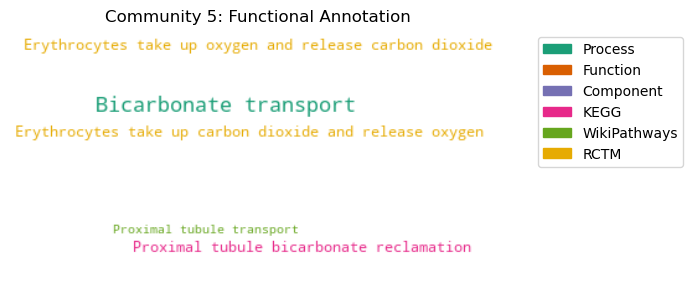

Saving word clouds to WordClouds/community 7's_wordcloud.png


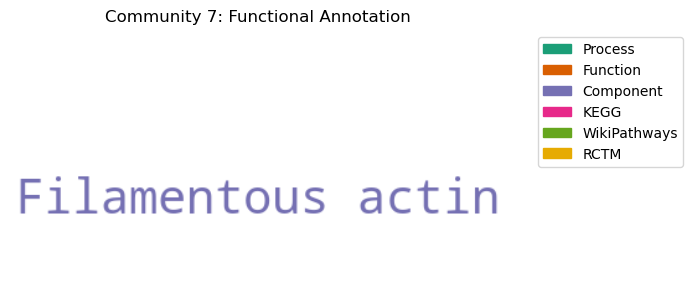

Saving word clouds to WordClouds/community 8's_wordcloud.png


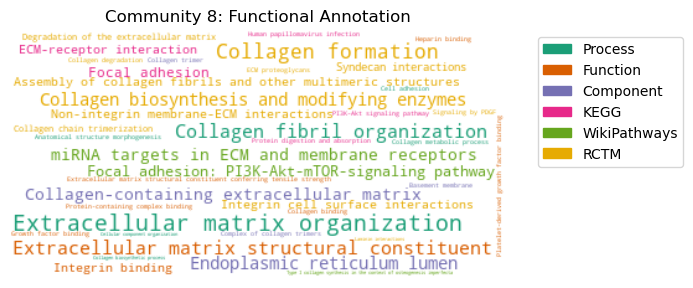

Saving word clouds to WordClouds/community 10's_wordcloud.png


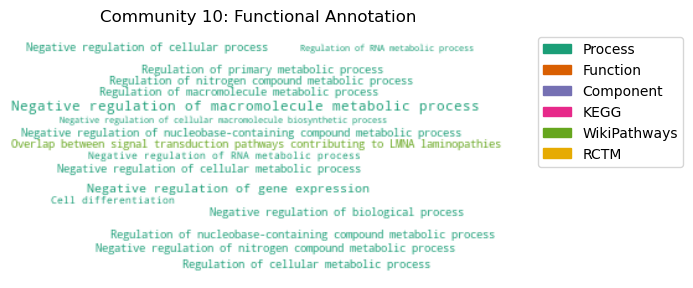

Saving word clouds to WordClouds/community 11's_wordcloud.png


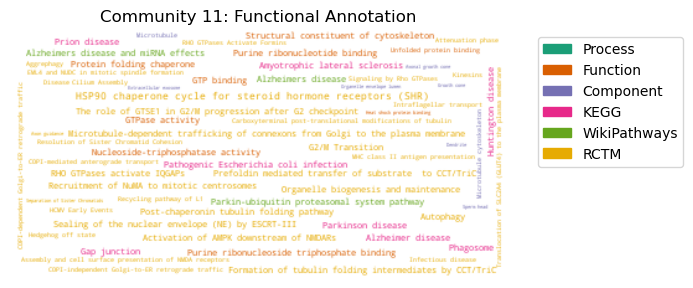

Saving interaction network to PPI_networks/community 0's_network.png


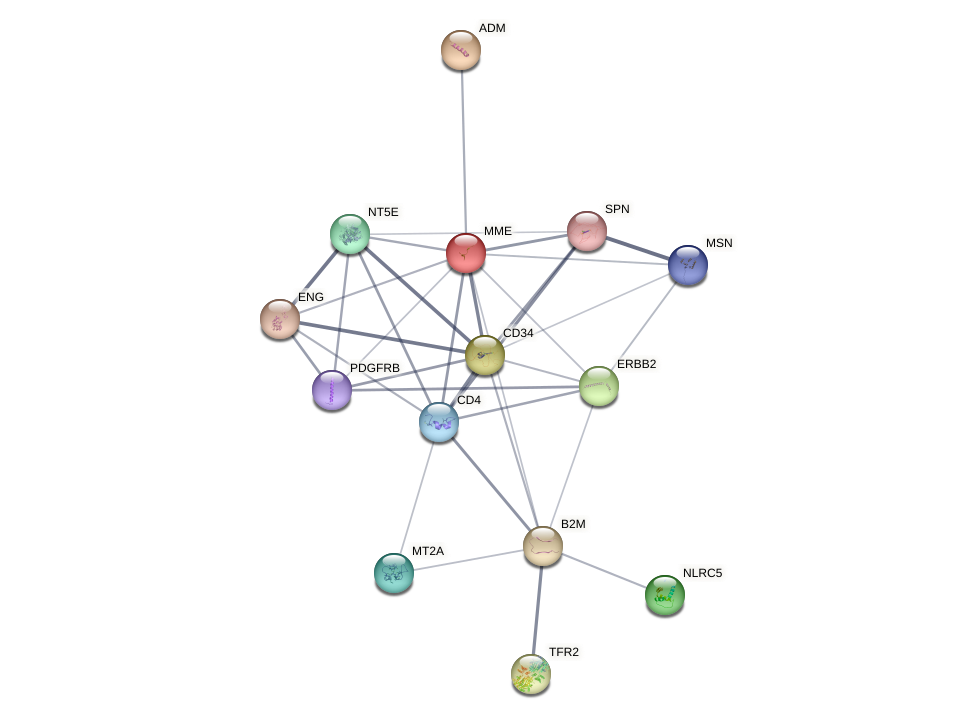

Saving interaction network to PPI_networks/community 1's_network.png


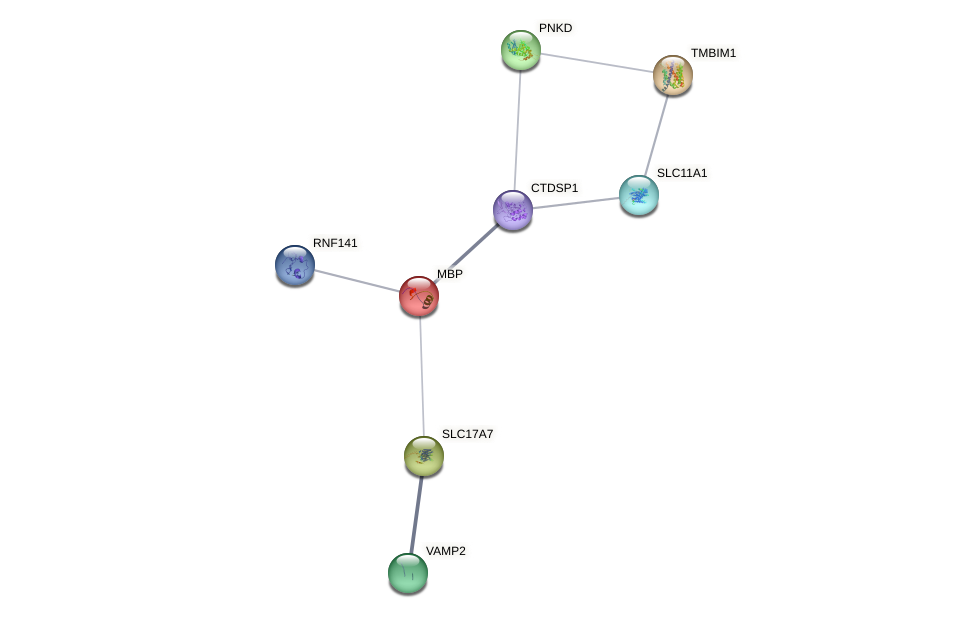

Saving interaction network to PPI_networks/community 3's_network.png


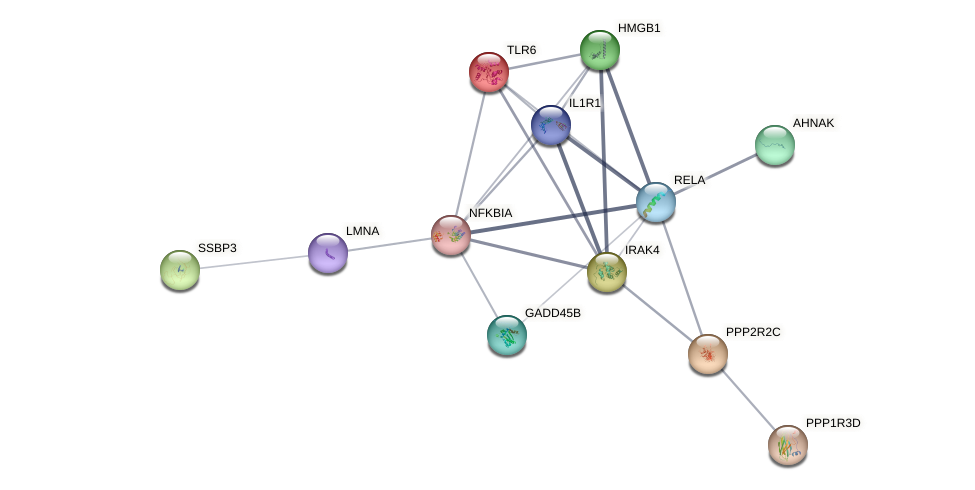

Saving interaction network to PPI_networks/community 4's_network.png


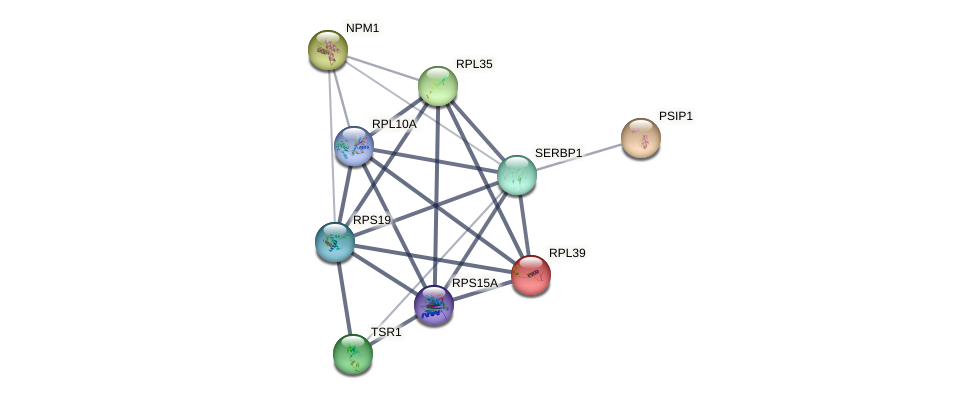

Saving interaction network to PPI_networks/community 5's_network.png


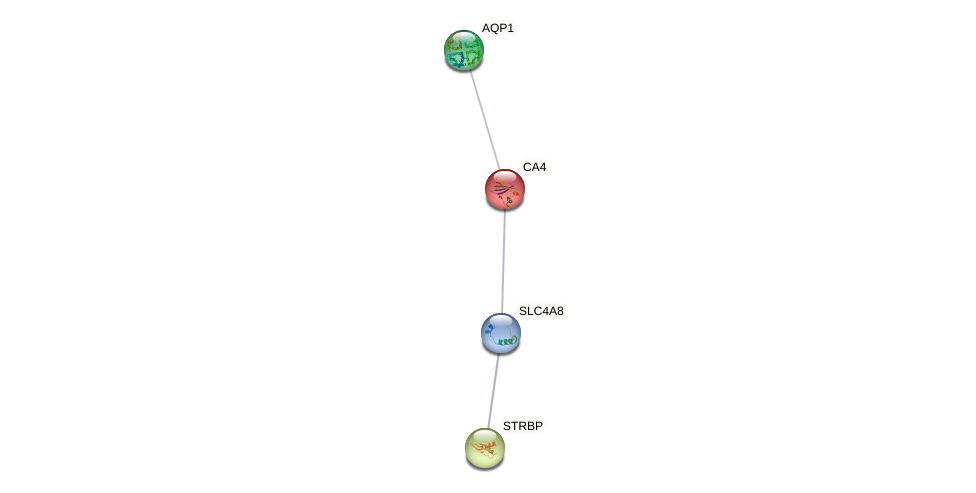

Saving interaction network to PPI_networks/community 7's_network.png


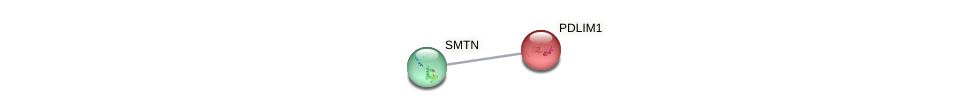

Saving interaction network to PPI_networks/community 8's_network.png


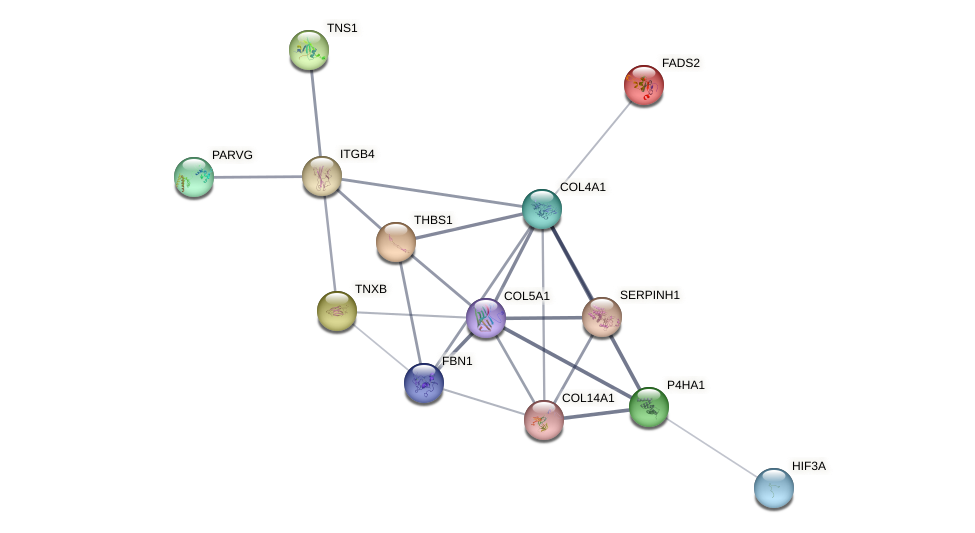

Saving interaction network to PPI_networks/community 10's_network.png


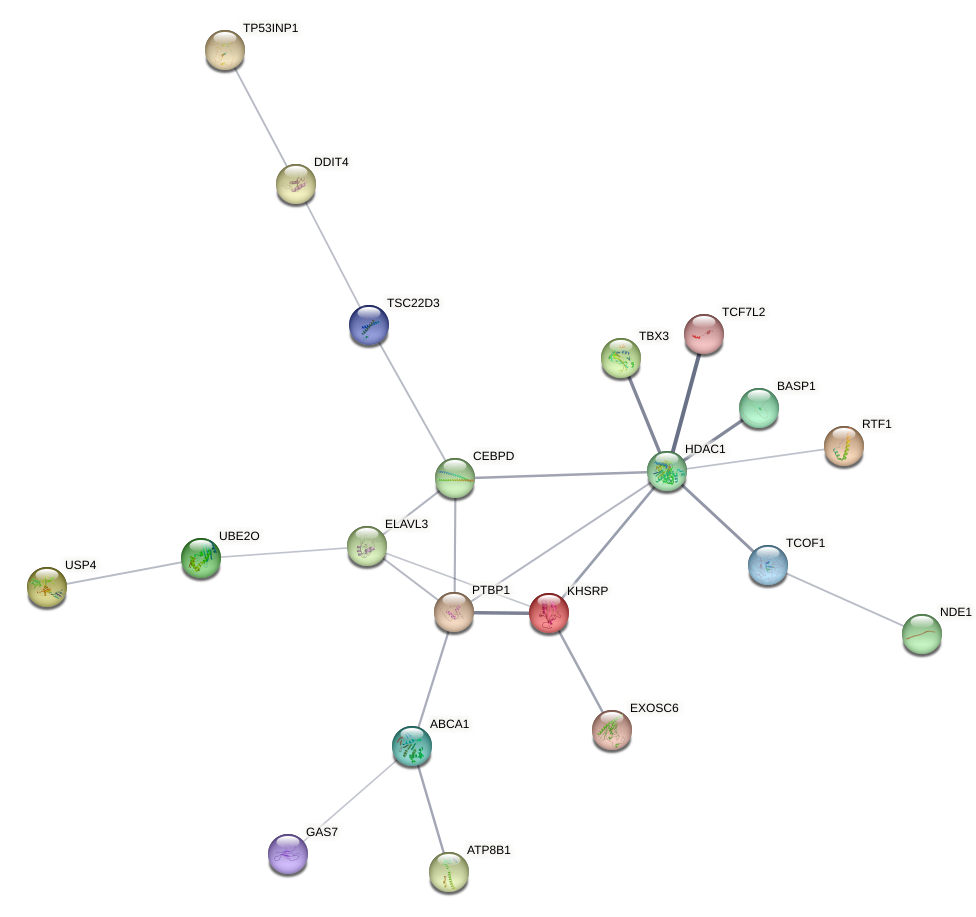

Saving interaction network to PPI_networks/community 11's_network.png


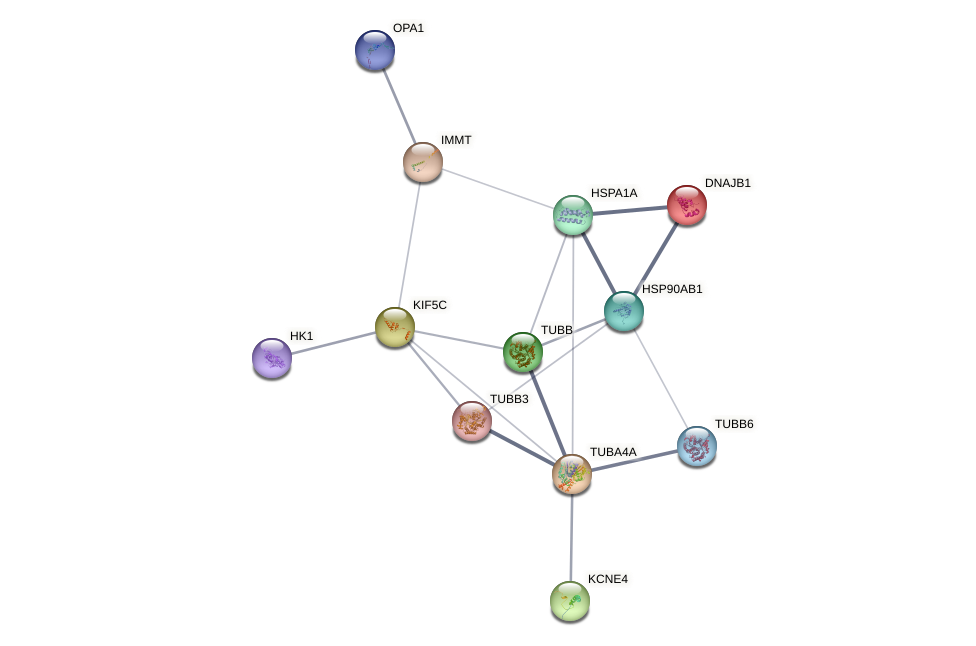

Saving interaction network to PPI_networks/community -1's_network.png


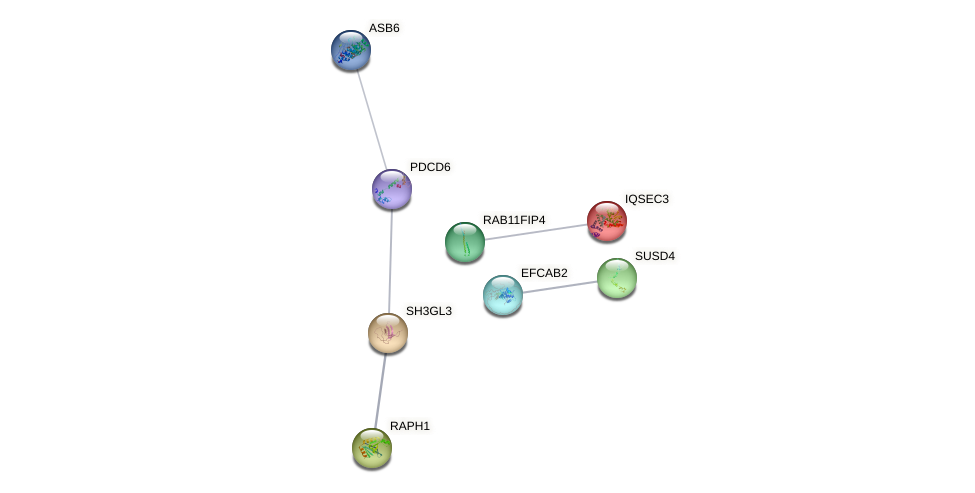

In [2]:
## Example

# define the list of genes/proteins of interest - here the 139 common transcripts from Ruffini, et al., 2020
identifiers = pd.Series(["COL4A1","CLK1","SMTN","PKD1","RAB11FIP4","CD34","NAV1","VAMP2","CEBPD","ERBB2","FBN1","STK38","NDE1","PNKD","THBS1","IQSEC3","SOBP","PSIP1","RFX2","RPS15A","MATN2","TUBB3","NFKBIA","KIF5C","TMEFF2","HK1","TNS1","LMNA","GADD45B","IMMT","BCAT2","IL1R1","TOB2","PGM2L1","PPP2R2C","AQP1","CA4","TCF7L2","TCOF1","MBNL3","RAB3IL1","SLC8A1","ABCC9","RTF1","IRAK4","APLNR","COL5A1","HDAC1","KHSRP","SERPINH1","RPS19","HSP90AB1","TUBB6","ANTXR1","MME","ADM","SH3D19","COL14A1","P4HA1","BASP1","SPTBN1","RELA","CNKSR3","GALNT6","SLITRK1","OPA1","STRBP","HIF3A","NLRC5","PDLIM1","PARVG","TUBA4A","ASB6","S1PR3","AHNAK","TSR1","CD4","HP1BP3","TMBIM1","TP53INP1","NPM1","SUSD4","TBX3","KCNAB1","SSBP3","SPN","SERBP1","ATP10B","EFCAB2","PTBP1","TLR6","DNAJB1","TFR2","SLC43A3","SLC11A1","TSC22D3","SLC7A1","PPP1R3D","FADS2","B2M","MKNK2","ELAVL3","PDGFRB","ATP8B1","ABCA1","EXOSC6","RNF141","SLC4A8","RPL10A","GAS7","KCNE4","ITGB4","MT2A","HMGB1","NAV2","MSN","HSDL2","ENG","PAQR6","ALPK1","MBP","DDIT4","HSPA1A","RAPH1","UBE2O","PDCD6","ARHGAP24","SH3GL3","RPL39","RNASET2","SLC17A7","ZBTB20","CTDSP1","TUBB","TNXB","RPL35","NT5E","USP4","MMRN2"])

# create a stringDB PPI network for these identifiers
G = get_string_ppi(identifiers)

# partition the network into communities (number of iterations is optional)
partition = createCommunities(G, iterations=100)

# plot the circos plots for these communities
plotCircos(G, partition)

# plot the arc plots for these communities
plotArc(G, partition)

# plot wordClouds and PPI networks for each significant community next to each other
gs, fa = plotWordCloudPPI(G, partition, categories=["KEGG", "WikiPathways", "RCTM"])

# plot wordClouds for each significant community
plotWordclouds(G, partition)

# plot PPI networks for each significant community
plotPPI(G, partition)


